# Traditional Classifiers with HMM Features

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from recurrent_health_events_prediction.training.utils import summarize_search_results
from recurrent_health_events_prediction.training.utils_traditional_classifier import plot_all_feature_importances


In [2]:
DATASET = "relapse"
USE_FIXED_DATA_SPLIT = True # if True, use a fixed data split, otherwise use a random split
CV_SCORING = "roc_auc" # metric to optimize during hyperparameter search
CV_N_FOLDS = 5 # number of folds for cross-validation
CV_N_ITER = 25 # number of iterations for randomized search
TEST_SIZE = 0.2  # proportion of the dataset to include in the test split
RANDOM_STATE = 56  # random state for reproducibility

## Choose HMM Model and Import Data

In [3]:
from recurrent_health_events_prediction.model.RecurrentHealthEventsHMM import RecurrentHealthEventsHMM
from recurrent_health_events_prediction.model.utils import load_model

if DATASET == "relapse":
    dataset_subdir = "drug_relapse"
else:
    dataset_subdir = "mimic"

model_name = "hmm_relapse_reduced_feats_set"
base_model_path = f"/workspaces/master-thesis-recurrent-health-events-prediction/_models/{dataset_subdir}/hmm"
hmm_features_dir = os.path.join(base_model_path, model_name)
model_pickle_path = os.path.join(hmm_features_dir, model_name + ".pkl")
hmm_feature_extractor_model: RecurrentHealthEventsHMM = load_model(model_pickle_path)
hmm_config = hmm_feature_extractor_model.config
print("HMM Model Config:")
for key, value in hmm_config.items():
    print(f"{key}: {value}")

HMM Model Config:
continuous_event_time_col: LOG_TIME_UNTIL_NEXT_POSITIVE
event_id_col: COLLECTION_ID
event_name: relapse
event_time_cat_col: RELAPSE_DURATION_CATEGORY
event_time_cat_order: ['0-30', '30-90', '90-180', '180+']
event_time_feature_col: LOG_TIME_UNTIL_NEXT_POSITIVE
feature_define_state_labels: LOG_TIME_UNTIL_NEXT_POSITIVE
features: {'ALCOHOL_POS': 'bernoulli', 'BUPRENORPHINE_POS': 'bernoulli', 'LOG_TIME_SINCE_LAST_NEGATIVE': 'gaussian', 'LOG_TIME_SINCE_LAST_POSITIVE': 'gaussian', 'LOG_TIME_UNTIL_NEXT_POSITIVE': 'gaussian', 'NUM_POSITIVES_SINCE_LAST_NEGATIVE': 'poisson'}
hidden_state_labels: ['high', 'medium', 'low']
id_col: DONOR_ID
model_name: hmm_relapse_reduced_feats_set
n_states: 3
save_model_path: /workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/hmm
time_col: RELAPSE_START
use_only_sequences_gte_2_steps: False


In [4]:
if DATASET == "mimic":
    target_event = "READMISSION_30_DAYS"  # target variable for multiclass analysis
elif DATASET == "relapse":
    target_event = "RELAPSE_30_DAYS"  # target variable for binary analysis

split_csv_path = os.path.join(hmm_features_dir, "train_test_split.csv")
event_id_col = hmm_config["event_id_col"]
id_col = hmm_config["id_col"]
prob_output_dir = f"/workspaces/master-thesis-recurrent-health-events-prediction/_models/{dataset_subdir}/hmm/{model_name}"
prob_output_filepath = os.path.join(prob_output_dir, "prob_predictions.csv")

print("Use fixed data split:", USE_FIXED_DATA_SPLIT)
if USE_FIXED_DATA_SPLIT:
    if not os.path.exists(split_csv_path):
        raise FileNotFoundError(f"Data split file not found: {split_csv_path}")
    else:
        print(f"Loading data split from {split_csv_path}...")
print(f"Target event: {target_event}")
print(f"Event ID column: {event_id_col}")
print(f"Subject ID column: {id_col}")
print(f"Test size: {TEST_SIZE}")
print(f"CV scoring metric: {CV_SCORING}")
print(f"Number of CV folds: {CV_N_FOLDS}")
print(f"Number of CV iterations: {CV_N_ITER}")
print(f"Random state: {RANDOM_STATE}")

Use fixed data split: True
Loading data split from /workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/hmm/hmm_relapse_reduced_feats_set/train_test_split.csv...
Target event: RELAPSE_30_DAYS
Event ID column: COLLECTION_ID
Subject ID column: DONOR_ID
Test size: 0.2
CV scoring metric: roc_auc
Number of CV folds: 5
Number of CV iterations: 25
Random state: 56


## Import Data and Define Features

In [5]:
training_data_path = hmm_features_dir
file_path = training_data_path + "/last_events_with_hidden_states.csv"
print(f"Loading last events from {file_path}")
last_events_with_hmm_feat_df = pd.read_csv(file_path)

Loading last events from /workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/hmm/hmm_relapse_reduced_feats_set/last_events_with_hidden_states.csv


In [6]:
last_events_with_hmm_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12289 entries, 0 to 12288
Data columns (total 62 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   index                              12289 non-null  int64  
 1   DONOR_ID                           12289 non-null  int64  
 2   COLLECTION_ID                      12289 non-null  int64  
 3   RELAPSE_START                      12289 non-null  object 
 4   RELAPSE_END                        12289 non-null  object 
 5   EVENT_DURATION                     12289 non-null  float64
 6   RELAPSE_EVENT                      12289 non-null  int64  
 7   NUM_TESTS_PERIOD                   12289 non-null  int64  
 8   NUM_PREV_RELAPSES                  12289 non-null  int64  
 9   RELAPSE_DURATION_CATEGORY          12289 non-null  object 
 10  RELAPSE_DURATION_CATEGORY_ENCODED  12289 non-null  int64  
 11  RELAPSE_30_DAYS                    12289 non-null  int

In [7]:
print("Final number of unique subjects: ", last_events_with_hmm_feat_df[id_col].nunique())
print("Final number of events: ", len(last_events_with_hmm_feat_df))

Final number of unique subjects:  12289
Final number of events:  12289


In [8]:
# Add a random feature for reference
np.random.seed(42)  # Ensure reproducibility
last_events_with_hmm_feat_df['RANDOM_FEATURE'] = np.random.rand(len(last_events_with_hmm_feat_df))

In [9]:
if DATASET == "mimic":
    base_features_cols = [
        "AGE",
        "CHARLSON_INDEX",
        "NUM_PREV_HOSPITALIZATIONS",
        "LOG_DAYS_SINCE_LAST_HOSPITALIZATION",
        "NUM_PROCEDURES",
        "LOG_DAYS_IN_ICU",
        "NUM_DRUGS",
        "HAS_DIABETES",
        "HAS_COPD",
        "HAS_CONGESTIVE_HF",
        "READM_30_DAYS_PAST_MEAN",
        "READM_30_DAYS_PAST_SUM",
        "PREV_READMISSION_30_DAYS",
        "LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN",
        "LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD",
    ]
    features_not_to_scale = [
        "HAS_DIABETES",
        "HAS_COPD",
        "HAS_CONGESTIVE_HF",
        "PREV_READMISSION_30_DAYS",
    ]
    plot_shap = (
        True  # Set to False if you do not want to plot SHAP feature importance
    )
    missing_features = {
        "READM_30_DAYS_PAST_MEAN": "median",
        "READM_30_DAYS_PAST_SUM": "median",
        "LOG_DAYS_SINCE_LAST_HOSPITALIZATION": "median",
        "LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN": "median",
        "LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD": "median",
    }
    last_events_with_hmm_feat_df['FIRST_HOSPITALIZATION'] = (
        last_events_with_hmm_feat_df['NUM_PREV_HOSPITALIZATIONS'] == 0).astype(int)

elif DATASET == "relapse":
    base_features_cols = [
        "PREV_NUM_DRUGS_POSITIVE",
        "LOG_PARTICIPATION_DAYS",
        "AGE",
        "DRUG_POSITIVE_PAST_SUM",
        "DRUG_POSITIVE_PAST_MEAN"
    ]
    plot_shap = True
    missing_features = {
        "LOG_TIME_RELAPSE_PAST_STD": "median",
        "RELAPSE_30_DAYS_PAST_MEAN": "median",
        "LOG_TIME_RELAPSE_PAST_MEAN": "median",
        "LOG_TIME_RELAPSE_PAST_MEDIAN": "median",
        "RELAPSE_30_DAYS_PAST_SUM": "median",
    }
    features_not_to_scale = []

hmm_prob_features = [
    col for col in last_events_with_hmm_feat_df.columns if "_HIDDEN_RISK_" in col
]

feature_cols = base_features_cols + ["RANDOM_FEATURE"] + hmm_prob_features

In [10]:
feature_cols

['PREV_NUM_DRUGS_POSITIVE',
 'LOG_PARTICIPATION_DAYS',
 'AGE',
 'DRUG_POSITIVE_PAST_SUM',
 'DRUG_POSITIVE_PAST_MEAN',
 'RANDOM_FEATURE',
 'PROB_HIDDEN_RISK_HIGH',
 'PROB_HIDDEN_RISK_MEDIUM',
 'PROB_HIDDEN_RISK_LOW',
 'PAST_COUNT_HIDDEN_RISK_HIGH',
 'PAST_COUNT_HIDDEN_RISK_LOW',
 'PAST_COUNT_HIDDEN_RISK_MEDIUM']

## Train-Test Split

In [11]:
from recurrent_health_events_prediction.training.utils import apply_train_test_split_file_classification

if USE_FIXED_DATA_SPLIT:
    if split_csv_path is None:
        raise ValueError("split_csv_path must be provided when use_fixed_train_test_split is True")
    print(f"Using fixed train-test split from {split_csv_path}")
    X_train, X_test, y_train, y_test, _, test_ids = (
        apply_train_test_split_file_classification(
            last_events_with_hmm_feat_df, split_csv_path, event_id_col, target_event, feature_cols
        )
    )
else:
    print("Using random train-test split...")
    X = last_events_with_hmm_feat_df[feature_cols + [event_id_col]]
    y = last_events_with_hmm_feat_df[target_event].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )
    test_ids = X_test[event_id_col].values
    X_train = X_train.drop(columns=[event_id_col])
    X_test = X_test.drop(columns=[event_id_col])

Using fixed train-test split from /workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/hmm/hmm_relapse_reduced_feats_set/train_test_split.csv


In [12]:
from recurrent_health_events_prediction.training.utils_traditional_classifier import (
    impute_missing_features,
    scale_features,
)

if missing_features:
    X_train, X_test = impute_missing_features(X_train, X_test, missing_features)

X_train_scaled, X_test_scaled = scale_features(
    X_train, X_test, features_not_to_scale=features_not_to_scale
)

Scaling features: ['PREV_NUM_DRUGS_POSITIVE', 'LOG_PARTICIPATION_DAYS', 'AGE', 'DRUG_POSITIVE_PAST_SUM', 'DRUG_POSITIVE_PAST_MEAN', 'RANDOM_FEATURE', 'PROB_HIDDEN_RISK_HIGH', 'PROB_HIDDEN_RISK_MEDIUM', 'PROB_HIDDEN_RISK_LOW', 'PAST_COUNT_HIDDEN_RISK_HIGH', 'PAST_COUNT_HIDDEN_RISK_LOW', 'PAST_COUNT_HIDDEN_RISK_MEDIUM']


## Models

In [13]:
print("Features used in the model:", feature_cols)
print("Target variable:", target_event)

Features used in the model: ['PREV_NUM_DRUGS_POSITIVE', 'LOG_PARTICIPATION_DAYS', 'AGE', 'DRUG_POSITIVE_PAST_SUM', 'DRUG_POSITIVE_PAST_MEAN', 'RANDOM_FEATURE', 'PROB_HIDDEN_RISK_HIGH', 'PROB_HIDDEN_RISK_MEDIUM', 'PROB_HIDDEN_RISK_LOW', 'PAST_COUNT_HIDDEN_RISK_HIGH', 'PAST_COUNT_HIDDEN_RISK_LOW', 'PAST_COUNT_HIDDEN_RISK_MEDIUM']
Target variable: RELAPSE_30_DAYS


In [15]:
X_train_scaled.head()

,PREV_NUM_DRUGS_POSITIVE,LOG_PARTICIPATION_DAYS,AGE,DRUG_POSITIVE_PAST_SUM,DRUG_POSITIVE_PAST_MEAN,RANDOM_FEATURE,PROB_HIDDEN_RISK_HIGH,PROB_HIDDEN_RISK_MEDIUM,PROB_HIDDEN_RISK_LOW,PAST_COUNT_HIDDEN_RISK_HIGH,PAST_COUNT_HIDDEN_RISK_LOW,PAST_COUNT_HIDDEN_RISK_MEDIUM
0,-0.261135,0.319501,-1.459706,-0.265590,-0.366320,-0.432629,-0.239201,-0.880132,0.998756,-0.316581,2.006071,-0.435919
1,-0.261135,-1.050756,0.717165,-0.500765,-1.355474,1.566180,-0.239201,1.179889,-1.070917,-0.316581,-0.996507,-0.155820
3,-0.261135,0.696913,-0.327733,-0.406695,0.118559,0.344861,-0.239201,-1.031288,1.150588,-0.316581,0.504782,-0.435919
4,-0.261135,1.255182,0.020566,2.838727,0.411026,-1.190703,-0.239201,1.151163,-1.041661,-0.316581,0.504782,7.406859
5,-0.261135,-0.613187,0.281791,-0.077449,1.394165,-1.190786,-0.239201,-0.833265,0.951678,-0.316581,0.504782,-0.435919


### Logistic Regression

In [16]:
param_dist_logreg = {
    'C': np.logspace(-4, 4, 100),  # 100 values between 1e-4 and 1e4
    'penalty': ['l2', 'l1'],             # 'l1' if solver supports it
    'class_weight': ['balanced'],
    'solver': ['liblinear'],
    'max_iter': [1000],
    'random_state': [42]
}

logreg_model = LogisticRegression()

random_search_logreg = RandomizedSearchCV(
    logreg_model,
    param_distributions=param_dist_logreg,
    n_iter=CV_N_ITER,  # or any number of random samples you want
    scoring=CV_SCORING,
    cv=CV_N_FOLDS,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)
random_search_logreg.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=25, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.9...
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
                                        'class_weight': ['balanced'],
                                        'max_iter': [1000],
                                        'penalty': ['l2', 'l1'],
                                        'random_state': [42],
                                        'solver': ['liblinear']},
                   random_state=56, scoring='roc_auc')

In [17]:
logreg_cv_search_results = summarize_search_results(random_search_logreg, print_results=True, model_name="Logistic Regression")

25 candidates of Logistic regression trained and validated with cross-validation on 5 folds.
Best parameters: {'solver': 'liblinear', 'random_state': 42, 'penalty': 'l1', 'max_iter': 1000, 'class_weight': 'balanced', 'C': np.float64(1.0974987654930568)}
Validation Score - Logistic regression: 0.699 ± 0.015


In [18]:
y_pred_proba_logreg = random_search_logreg.predict_proba(X_test_scaled)
y_pred_logreg = random_search_logreg.predict(X_test_scaled)

if y_pred_proba_logreg.ndim > 1:
    y_pred_proba_logreg = y_pred_proba_logreg[:, 1]  # Get probabilities for the positive class

roc_auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)

print("Logistic Regression model evaluation:")
print("AUC:", roc_auc_logreg)
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))

Logistic Regression model evaluation:
AUC: 0.7015673989534704
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.70      0.65      1142
           1       0.70      0.61      0.65      1316

    accuracy                           0.65      2458
   macro avg       0.66      0.66      0.65      2458
weighted avg       0.66      0.65      0.65      2458



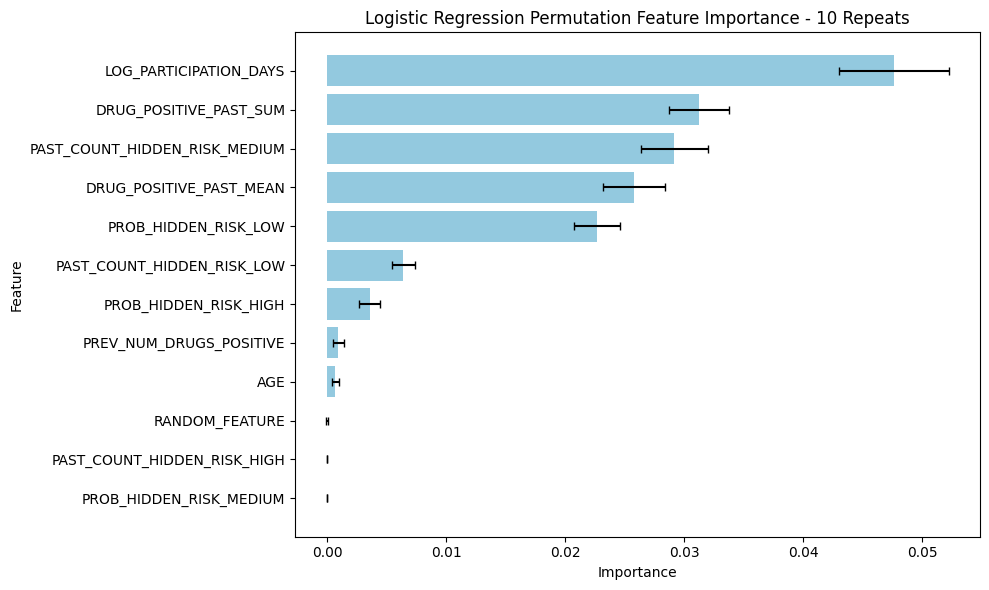

Calculating SHAP values for 3000 samples...


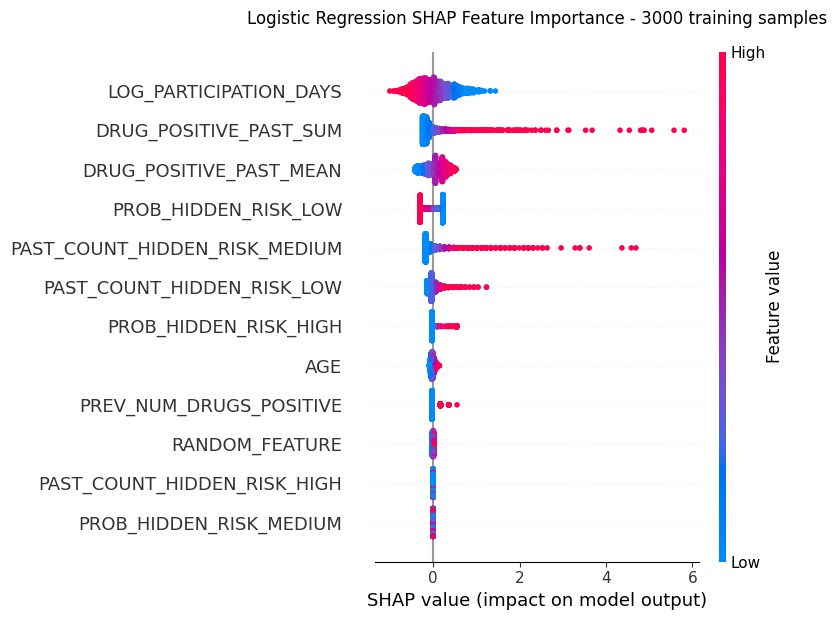

In [19]:
plot_all_feature_importances(
    random_search_logreg.best_estimator_,
    X_train_scaled,
    y_train,
    model_name="Logistic Regression",
    neptune_run=None,
    random_state=RANDOM_STATE,
    plot_shap=plot_shap,
    show_plots=True
)

### Random Forest

In [20]:
rf_model = RandomForestClassifier(
    random_state=RANDOM_STATE, class_weight='balanced')

rand_search_params = {
    'n_estimators': [50, 75, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


random_search_rf = RandomizedSearchCV(rf_model, rand_search_params, cv=CV_N_FOLDS,
                                      scoring=CV_SCORING, n_iter=CV_N_ITER, random_state=RANDOM_STATE, n_jobs=-1)
random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=56),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 75, 100, 150,
                                                         200]},
                   random_state=56, scoring='roc_auc')

In [21]:
rf_cv_search_results = summarize_search_results(random_search_rf, print_results=True, model_name="Random Forest")

25 candidates of Random forest trained and validated with cross-validation on 5 folds.
Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
Validation Score - Random forest: 0.706 ± 0.014


In [22]:
y_pred_proba_rf = random_search_rf.predict_proba(X_test)
y_pred_rf = random_search_rf.predict(X_test)

if y_pred_proba_rf.ndim > 1:
    y_pred_proba_rf = y_pred_proba_rf[:, 1]  # Get probabilities for the positive class

roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print("Random Forest model evaluation:")
print("AUC:", roc_auc_rf)
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest model evaluation:
AUC: 0.7109733896166806
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.65      0.63      1142
           1       0.68      0.64      0.66      1316

    accuracy                           0.65      2458
   macro avg       0.65      0.65      0.65      2458
weighted avg       0.65      0.65      0.65      2458



In [23]:
importances = random_search_rf.best_estimator_.feature_importances_
feature_importance_series = pd.Series(importances, index=random_search_rf.best_estimator_.feature_names_in_)
feature_importance_series.sort_values(ascending=False, inplace=True)
print("Feature importances:")
feature_importance_df = feature_importance_series.reset_index()
feature_importance_df.columns = ['Feature', 'Importance']
feature_importance_df

Feature importances:


,Feature,Importance
0,DRUG_POSITIVE_PAST_MEAN,0.157500
1,DRUG_POSITIVE_PAST_SUM,0.157281
2,PROB_HIDDEN_RISK_LOW,0.145336
3,LOG_PARTICIPATION_DAYS,0.142277
4,RANDOM_FEATURE,0.087577
5,PROB_HIDDEN_RISK_MEDIUM,0.085102
6,AGE,0.068922
7,PAST_COUNT_HIDDEN_RISK_MEDIUM,0.062915
8,PROB_HIDDEN_RISK_HIGH,0.035700
9,PAST_COUNT_HIDDEN_RISK_LOW,0.025929


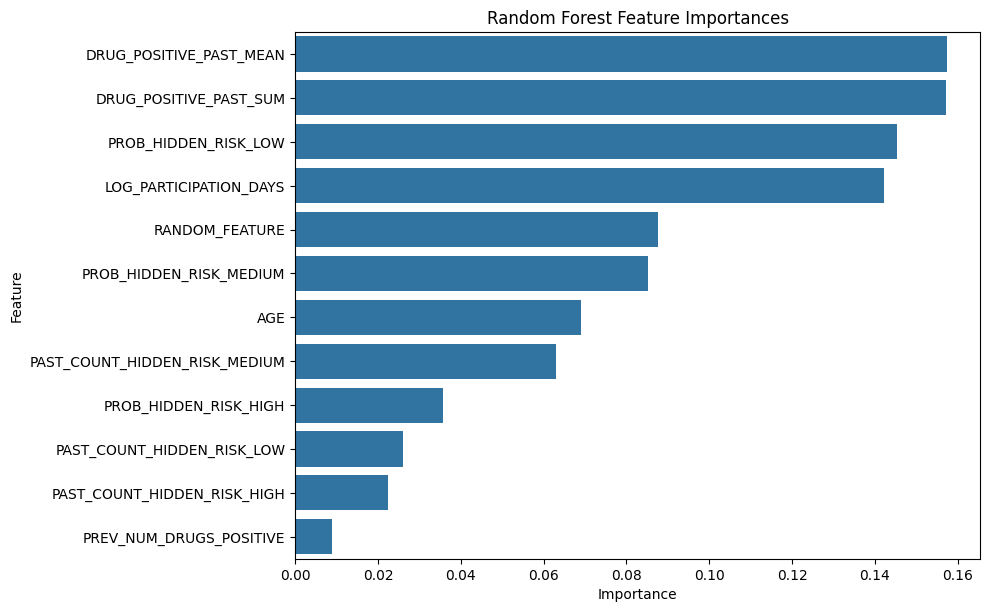

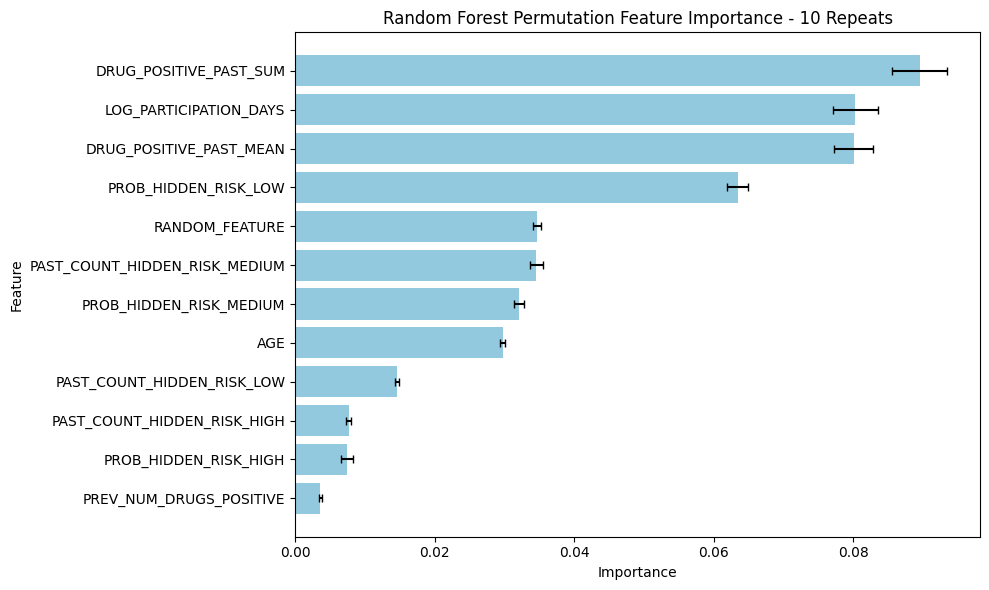

Calculating SHAP values for 3000 samples...


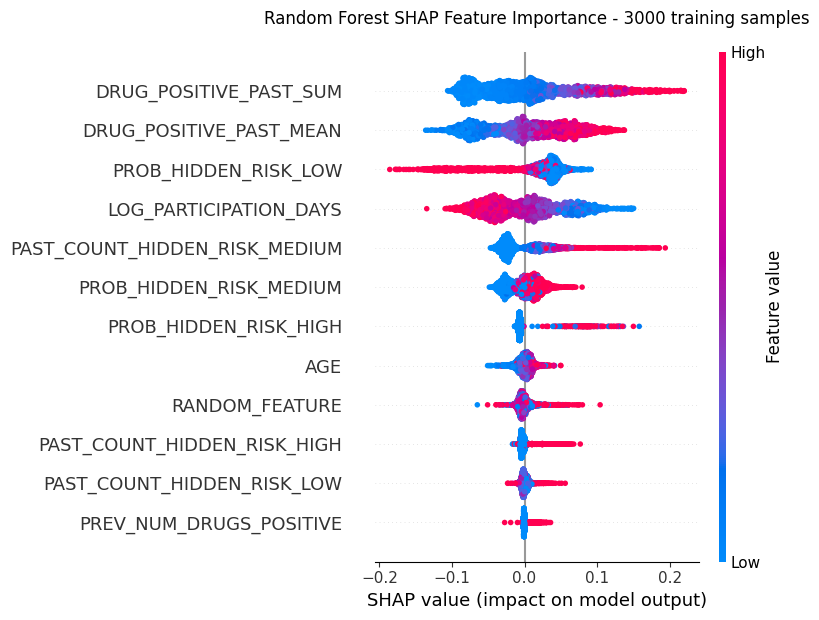

In [24]:
plot_all_feature_importances(
    random_search_rf.best_estimator_,
    X_train,
    y_train,
    model_name="Random Forest",
    neptune_run=None,
    random_state=RANDOM_STATE,
    plot_shap=plot_shap,
    show_plots=True
)

### LightGBM

In [25]:
lgbm_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 4, 6, -1],
    "min_child_samples": [5, 10, 20, 30],
    "num_leaves": [7, 15, 31],
    "subsample": [0.6, 0.8, 1.0],
    "feature_fraction": [0.6, 0.8, 1.0],
}

lgbm = LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced', objective="binary")

random_search_lgbm = RandomizedSearchCV(
    lgbm,
    lgbm_param_grid,
    n_iter=2,  # Increase for more thorough search
    scoring=CV_SCORING,
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1  # Use all cores
)

# Train the model
random_search_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGB

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            objective='binary',
                                            random_state=56),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'feature_fraction': [0.6, 0.8, 1.0],
                                        'max_depth': [3, 4, 6, -1],
                                        'min_child_samples': [5, 10, 20, 30],
                                        'n_estimators': [50, 100, 200],
                                        'num_leaves': [7, 15, 31],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=56, scoring='roc_auc')

In [26]:
lgbm_cv_search_results = summarize_search_results(random_search_lgbm, print_results=True, model_name="LightGBM")

2 candidates of Lightgbm trained and validated with cross-validation on 5 folds.
Best parameters: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 200, 'min_child_samples': 10, 'max_depth': 3, 'feature_fraction': 0.8}
Validation Score - Lightgbm: 0.705 ± 0.015


In [27]:
# Probabilities for AUC
y_pred_proba_lgbm = random_search_lgbm.predict_proba(X_test)  # shape: (n_samples, n_classes)
y_pred_lgbm = random_search_lgbm.predict(X_test)

if y_pred_proba_lgbm.ndim > 1:
    y_pred_proba_lgbm = y_pred_proba_lgbm[:, 1]  # Get probabilities for the positive class
    
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
print(f"LightGBM ROC AUC: {roc_auc_lgbm:.3f}")
print(classification_report(y_test, y_pred_lgbm))


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
LightGBM ROC AUC: 0.714
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      1142
           1       0.70      0.65      0.67      1316

    accuracy                           0.66      2458
   macro avg       0.66      0.66      0.66      2458
weighted avg       0.66      0.66      0.66      2458



In [28]:
importances = random_search_lgbm.best_estimator_.feature_importances_
features = random_search_lgbm.best_estimator_.feature_names_in_
importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

importance_df


,feature,importance
1,LOG_PARTICIPATION_DAYS,236
4,DRUG_POSITIVE_PAST_MEAN,207
5,RANDOM_FEATURE,171
3,DRUG_POSITIVE_PAST_SUM,164
7,PROB_HIDDEN_RISK_MEDIUM,115
11,PAST_COUNT_HIDDEN_RISK_MEDIUM,110
8,PROB_HIDDEN_RISK_LOW,104
2,AGE,103
6,PROB_HIDDEN_RISK_HIGH,55
10,PAST_COUNT_HIDDEN_RISK_LOW,49


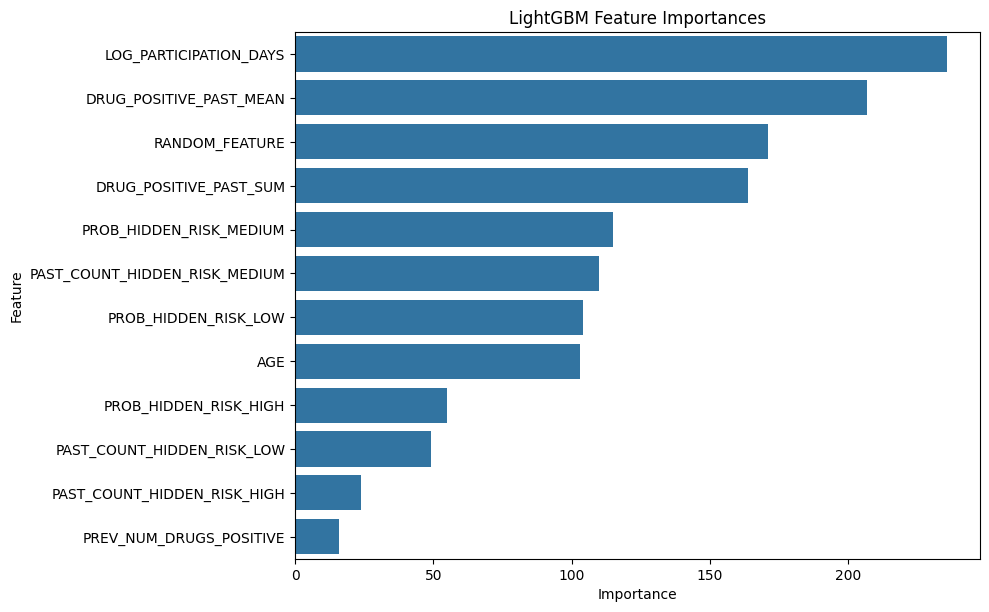

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGB

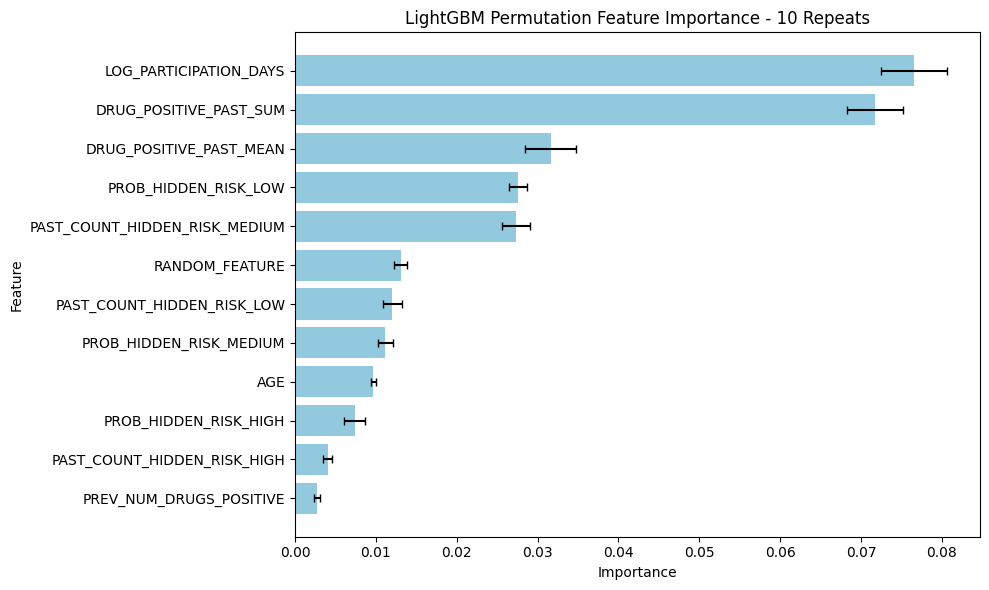

Calculating SHAP values for 3000 samples...


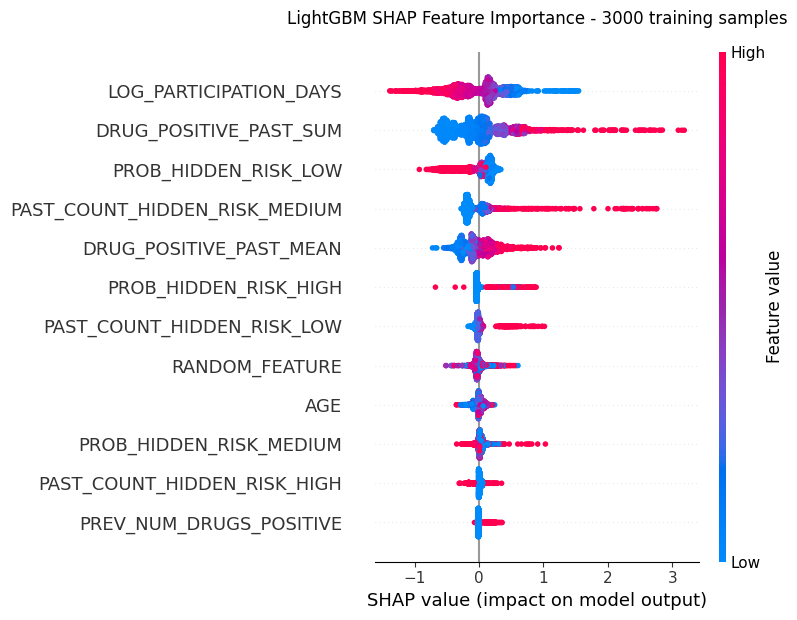

In [29]:
plot_all_feature_importances(
    random_search_lgbm.best_estimator_,
    X_train,
    y_train,
    model_name="LightGBM",
    neptune_run=None,
    random_state=RANDOM_STATE,
    plot_shap=plot_shap,
    show_plots=True
)

## Final Results

In [30]:
print("Training samples used for the models:", len(X_train))
print("Test samples used for the models:", len(X_test))

Training samples used for the models: 9831
Test samples used for the models: 2458


In [31]:
random_search_results = [logreg_cv_search_results, rf_cv_search_results, lgbm_cv_search_results]

results = {
    "Model": ["Logistic Regression", "Random Forest", "LightGBM"],
    "Number of Candidates in CV": [cv_results["n_fitted_candidates"] for cv_results in random_search_results],
    "Mean AUC CV": [cv_results["best_score_mean"] for cv_results in random_search_results],
    "Std AUC CV": [cv_results["best_score_std"] for cv_results in random_search_results],
    "Evaluation AUC 30 Days": [roc_auc_logreg, roc_auc_rf, roc_auc_lgbm],
}

results_df = pd.DataFrame(results)
results_df

,Model,Number of Candidates in CV,Mean AUC CV,Std AUC CV,Evaluation AUC 30 Days
0,Logistic Regression,25,0.698561,0.015200,0.701567
1,Random Forest,25,0.706037,0.013523,0.710973
2,LightGBM,2,0.704803,0.014644,0.713520


In [32]:
prob_output_filepath

'/workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/hmm/hmm_relapse_reduced_feats_set/prob_predictions.csv'

In [33]:
from recurrent_health_events_prediction.training.utils_traditional_classifier import save_prob_predictions


if USE_FIXED_DATA_SPLIT:
    print("Saving probability predictions...")
    print("Output path for probability predictions: ", prob_output_filepath)
    if prob_output_filepath is None:
        raise ValueError("prob_output_filepath must be provided when use_fixed_train_test_split is True")
    y_pred_proba_dict = {
        "logreg": y_pred_proba_logreg,
        "rf": y_pred_proba_rf,
        "lgbm": y_pred_proba_lgbm,
    }
    save_prob_predictions(
        out_path=prob_output_filepath,
        id_series=test_ids,
        y_true=y_test,
        proba_dict=y_pred_proba_dict,
        file_format="csv"  # Change to "parquet" if needed
    )

Saving probability predictions...
Output path for probability predictions:  /workspaces/master-thesis-recurrent-health-events-prediction/_models/drug_relapse/hmm/hmm_relapse_reduced_feats_set/prob_predictions.csv
